In [1]:
# main function that sets up environments
# perform training loop
import os
os.environ["PATH"] += os.pathsep + '/opt/X11/bin'
# import envs
from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor

from pettingzoo.mpe import simple_adversary_v2

# keep training awake
from workspace_utils import keep_awake

# for saving gif
import imageio

In [2]:
def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [6]:
def train():
    seeding()
    # number of parallel agents
    # parallel_envs = 1
    # number of training episodes.
    # change this to higher number to experiment. say 30000.
    number_of_episodes = 1001
    episode_length = 100
    batchsize = 256
    # how many episodes to save policy and gif
    save_interval = 50
    # t = 0
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 0.5
    noise_reduction = 1.0

    # how many episodes before update
    episode_per_update = 1

    log_path = os.getcwd()+"/log"
    model_dir= os.getcwd()+"/model_dir"
    
    os.makedirs(model_dir, exist_ok=True)

    env = simple_adversary_v2.env(continuous_actions=True, render_mode='rgb_array', max_cycles=episode_length)
     
    # keep 5000 episodes worth of replay
    buffer_size = int(5000*episode_length)
    buffer = ReplayBuffer(buffer_size)
    
    # initialize policy and critic
    maddpg = MADDPG()
    logger = SummaryWriter(log_dir=log_path)


    scores = []
    avg_scores = []

    # training loop
 
    # use keep_awake to keep workspace from disconnecting
    for episode in range(0, number_of_episodes):

        reward_this_episode = np.zeros(3)
        env.reset() #
        agents = env.agents
        num_agents = env.num_agents

        # dummy_action = torch.tensor(np.zeros(5,))
        dummy_action = torch.tensor(np.zeros(5,))
        obs = [env.observe(agent) for agent in agents]
       
        for _ in range(num_agents):
            env.step(dummy_action)

        #for calculating rewards for this particular episode - addition of all time steps

        # save info or not
        save_info = (episode) % save_interval == 0
        frames = []
        
        tmax = 0
        
        # if save_info:
        #     frames.append(env.render('rgb_array'))
        
        for episode_t in range(episode_length):
            
            # explore = only explore for a certain number of episodes
            # action input needs to be transposed
            # obs_tensor = [torch.tensor(ob, dtype=torch.float32) for ob in obs]
            # actions = maddpg.act(obs_tensor, noise=noise)
            actions = maddpg.act(obs, noise=noise)
            # actions = [action.clip(0.0, 1.0).detach().numpy() for action in actions]

            noise *= noise_reduction
            
            # step forward one frame
            next_obs, rewards, dones, infos = [], [], [], []
            for i in range(num_agents): 
                next_ob, reward, termination, truncation, info = env.last()
                done = termination or truncation
                if done:
                    break
                next_obs.append(next_ob)
                rewards.append(reward)
                dones.append(done)
                infos.append(info)
                env.step(actions[i])
            
            if done:
                break
            # print(len(actions), len(actions[0]))
            # raise
            transition = (obs, actions, rewards, next_obs, dones)
            buffer.push(transition)
            
            reward_this_episode += rewards

            obs = next_obs
            # save gif frame
            if save_info:
                frames.append(env.render())
                tmax+=1
        
        if len(buffer) > batchsize and episode % episode_per_update == 0:
            samples = buffer.sample(batchsize)
            # a_i = 0
            for a_i in range(num_agents):
                # samples = buffer.sample(batchsize)
                maddpg.update(samples, a_i, logger)
                maddpg.update_targets() #soft update the target network towards the actual networks

        # score = reward_this_episode
        scores.append(reward_this_episode)
        
        if (episode % 100 == 0 or episode == number_of_episodes-1) and episode > 0:
            # avg_rewards = [np.mean(agent0_reward), np.mean(agent1_reward), np.mean(agent2_reward)]
            avg_rewards = [np.mean(score) for score in zip(*scores[-100:])]
            avg_scores.append(avg_rewards)
            print("Episode: {}, score: {}".format(episode, np.mean(avg_rewards)))
            # scores = []
            for a_i, avg_rew in enumerate(avg_rewards):
                logger.add_scalar('agent%i/mean_episode_rewards' % a_i, avg_rew, episode)

        #saving model
        save_dict_list =[]
        if save_info:
            for i in range(3):

                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}.pt'.format(episode)))
                
            # save gif files
            imageio.mimsave(os.path.join(model_dir, 'episode-{}.gif'.format(episode)), 
                            frames, duration=.04)
    return avg_scores
    # env.close()
    # logger.close()

In [7]:
scores = train()

/Users/johnlockwood/mambaforge/envs/zoo/lib/python3.10/site-packages/gymnasium/spaces/box.py:228: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


Episode: 100, score: -40.05787359322337
Episode: 200, score: -77.82077261706523
Episode: 300, score: -72.28530135433046
Episode: 400, score: -57.62859117640992
Episode: 500, score: -25.812635626685296
Episode: 600, score: -10.047568076364618
Episode: 700, score: -5.630053189379368
Episode: 800, score: -5.075273695031555
Episode: 900, score: -4.844751563590833
Episode: 1000, score: -4.43001009877479


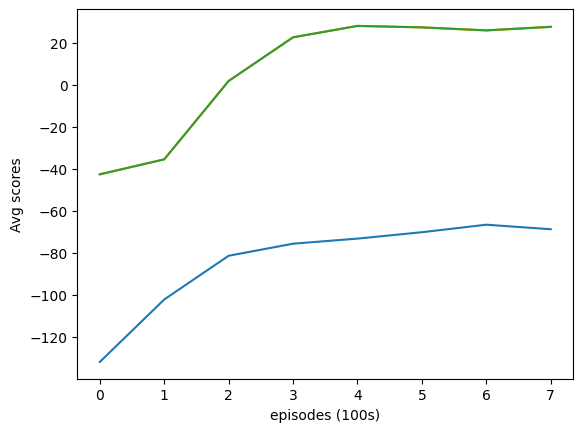

In [12]:
import matplotlib.pyplot as plt
plt.ylabel("Avg scores")
plt.xlabel("episodes (100s)")
plt.plot(scores[2:])